In [1]:
seed = 42 # Seed for reproducibility 

import os

# Environment variables 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Datasets
os.environ['TRAINING_SET'] = '/kaggle/input/lung-cancer/Mohammad_Preprocessing/Mohammad_Preprocessing/train_set.npz'
os.environ['VALIDATION_SET'] = '/kaggle/input/lung-cancer/Mohammad_Preprocessing/Mohammad_Preprocessing/val_set.npz'

# Suppress warnings 
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.simplefilter(action='ignore', category=Warning)

# Necessary modules
import logging
import random 
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.manifold import TSNE

# Set seeds 
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Suppress tensorflow messages
# tf.autograph.set_verbosity(0)
# tf.get_logger().setLevel(logging.ERROR)
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


# Plot settings
sns.set(font_scale=1.4)
sns.set_style=('white')
sns.set_palette=('flare')
plt.rc('font', size=14)
%matplotlib inline

In [2]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

## Load Data

In [3]:
def one_hot_encode_labels(labels): 
    labels = np.array(labels).reshape(-1, 1)
    encoder = OneHotEncoder(sparse_output=False)
    return encoder.fit_transform(labels)

In [4]:
def rescale_images(images, scaler=StandardScaler()):
    flattened = np.concatenate([image.flatten().reshape(1, -1) for image in images])
    scaled = scaler.fit_transform(flattened)
    
    # Reshape the scaled data back into the original shape of each image
    reshaped = [scaled[i].reshape(images[i].shape) for i in range(len(images))]
    return reshaped

In [5]:
def load_data(dataset_path=os.environ['TRAINING_SET'], preprocess=True, label_transformer=None, scaler=None):
    data = np.load(dataset_path)

    print(data)
    
    full_slices = data['full_slices']
    nodules = data['nodules']
    tumor_classes = data['labels']    

    if preprocess == False: 
        return (full_slices, nodules, tumor_classes)

    if label_transformer is not None: 
        tumor_classes = label_transformer(tumor_classes)

    if scaler is not None: 
        full_slices = scaler(full_slices)
        nodules = scaler(nodules)

    return (full_slices, nodules, tumor_classes)    

In [6]:
X_train, nodules_train, y_train = load_data(
    preprocess=True, 
    label_transformer=one_hot_encode_labels
)

X_validation, nodules_validation, y_validation = load_data(
    os.environ['VALIDATION_SET'], 
    preprocess=True, 
    label_transformer=one_hot_encode_labels
)

NpzFile '/kaggle/input/lung-cancer/Mohammad_Preprocessing/Mohammad_Preprocessing/train_set.npz' with keys: full_slices, nodules, labels
NpzFile '/kaggle/input/lung-cancer/Mohammad_Preprocessing/Mohammad_Preprocessing/val_set.npz' with keys: full_slices, nodules, labels


In [7]:
print(f'Training set: {X_train.shape}, {y_train.shape}')
print(f'Training set: {X_validation.shape}, {y_validation.shape}')

Training set: (3089, 512, 512, 3), (3089, 5)
Training set: (309, 512, 512, 3), (309, 5)


## Network definition 

In [8]:
vgg_backbone = tfk.applications.VGG16(weights='imagenet', include_top=False, input_shape=X_train.shape[1:])
vgg_backbone.trainable = False

# Classification head
x = vgg_backbone.output
x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Dense(256, activation='silu')(x)
x = tfkl.Dense(128, activation='silu')(x)
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax')(x)

model = tfk.Model(inputs=vgg_backbone.input, outputs=outputs)
model.compile(
    optimizer='adam', 
    loss='categorical_focal_crossentropy',
    metrics=['accuracy', 'recall']
)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 512, 512, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast (Cast)                          │ (None, 512, 512, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 512, 512, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 512, 512, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 256, 256, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 256, 256, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 128, 128, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 128, 128, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 128, 128, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 64, 64, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 64, 64, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 64, 64, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │              

 Total params: 14,879,557 (56.76 MB)

 Trainable params: 164,869 (644.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Model training

In [9]:
EPOCHS = 10
BATCH_SIZE = 32

In [9]:
fitted_model = model.fit(
    X_train,
    y_train,
    validation_data = (X_validation, y_validation),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 101s 690ms/step - accuracy: 0.2458 - loss: 0.4012 - recall: 0.0645 - val_accuracy: 0.4563 - val_loss: 0.2325 - val_recall: 0.2427
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 31s 322ms/step - accuracy: 0.3503 - loss: 0.2210 - recall: 0.0557 - val_accuracy: 0.4757 - val_loss: 0.2263 - val_recall: 0.1586
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 31s 322ms/step - accuracy: 0.4014 - loss: 0.2030 - recall: 0.0618 - val_accuracy: 0.4822 - val_loss: 0.2289 - val_recall: 0.1909
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 31s 321ms/step - accuracy: 0.4289 - loss: 0.1904 - recall: 0.0859 - val_accuracy: 0.4337 - val_loss: 0.2277 - val_recall: 0.1327
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 31s 321ms/step - accuracy: 0.4741 - loss: 0.1754 - recall: 0.1113 - val_accuracy: 0.4531 - val_loss: 0.2394 - val_recall: 0.1650
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 31s 321ms/step - accuracy: 0.4994 - loss: 0.1635 - recall: 0.1544 - val_accuracy: 0.4563 - val_loss: 0.2515 - val_recall: 0.25

## GradCAM

In [10]:
def compute_gradcam(model, image, class_, output_layer): 
    grad_model = tfk.Model([model.inputs], [model.get_layer(output_layer).output, model.outputs])
    with tf.GradientTape() as tape: 
        conv_outputs, predictions = grad_model(tf.expand_dims(image, axis=0))
        loss = predictions[0][0][class_]
        print(f'Predicted: {tf.argmax(predictions[0][0])}; Actual: {class_}')
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [11]:
def plot_gradcam(image, heatmap, nodule): 
    heatmap = np.uint8(255 * heatmap)
    heatmap = tf.image.resize(tf.expand_dims(heatmap, axis=-1), (image.shape[0], image.shape[1])).numpy()
    heatmap = np.squeeze(heatmap)

    fig, axs = plt.subplots(1, 3, dpi=300)
    axs[0].imshow(image, cmap='gray')
    axs[0].axis('off')

    axs[1].imshow(image, cmap='gray')
    axs[1].imshow(heatmap, cmap='jet', alpha=0.5)
    axs[1].axis('off')
    
    axs[2].imshow(nodule)
    axs[2].axis('off')
    
    plt.show()

In [12]:
def plot_cams(full_scans, nodules, labels, model, indices, output_layer):
    for idx in indices: 
        image = full_scans[idx]
        label = np.argmax(labels[idx])
        nodule = nodules[idx]
        heatmap = compute_gradcam(model, image, label, output_layer)
        plot_gradcam(image, heatmap, nodule) 

Predicted: 2; Actual: 3


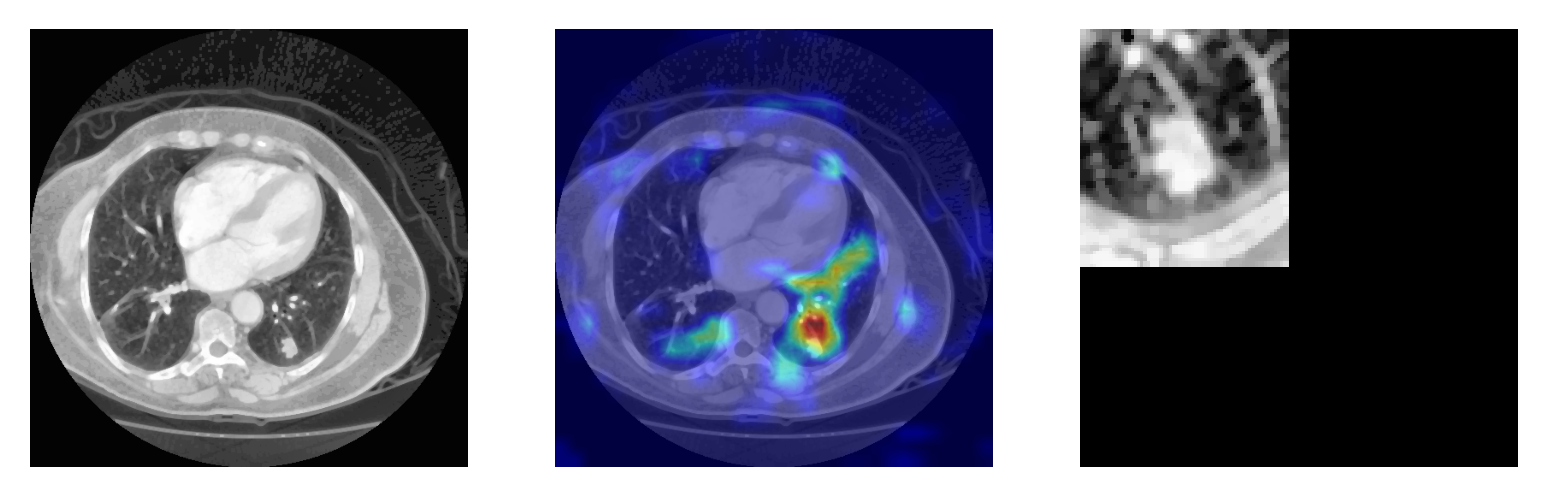

Predicted: 1; Actual: 1


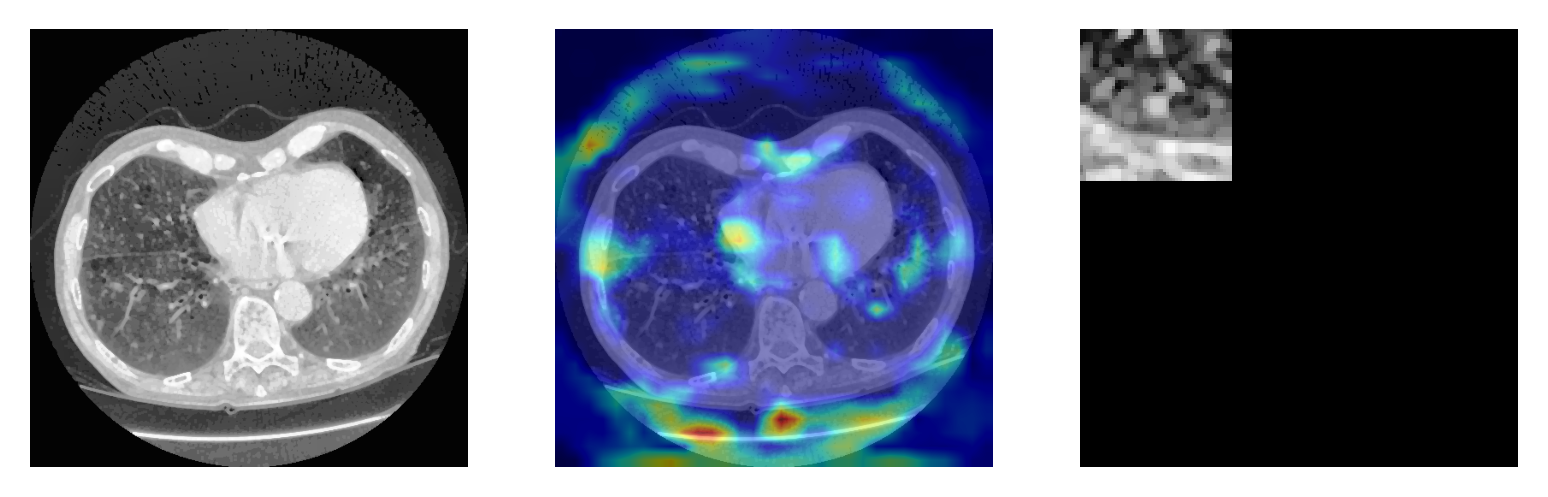

Predicted: 2; Actual: 3


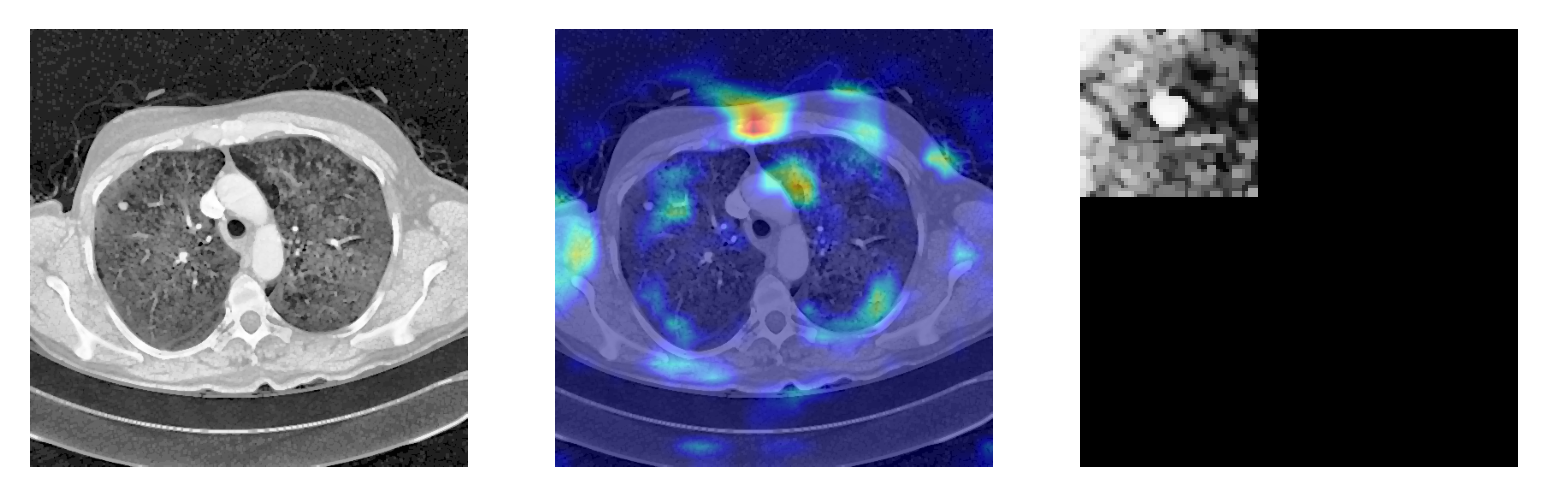

Predicted: 1; Actual: 2


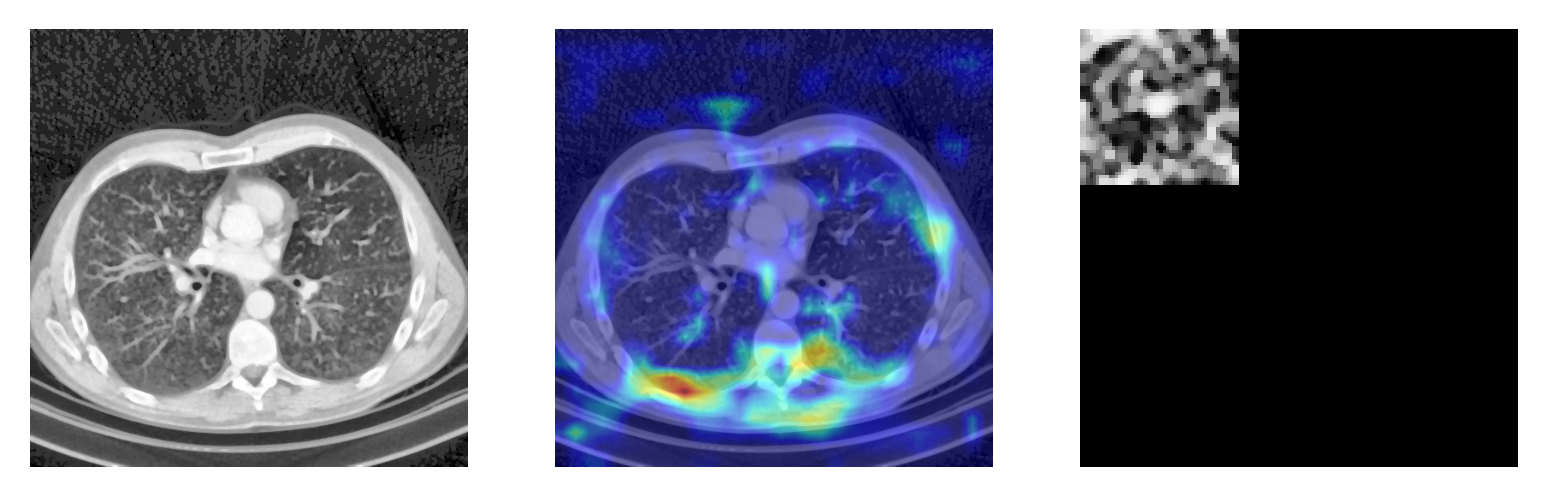

In [13]:
indeces_to_show = [42, 0, 1, 2]
plot_cams(X_validation, nodules_validation, y_validation, model, indices=indeces_to_show, output_layer='block5_conv3')

## t-SNE visualization of Latent Space (LS)

In [14]:
def extract_latent_features(model, images, output_layer): 
    feature_model = tfk.Model(inputs=model.input, outputs=model.get_layer(output_layer).output)
    latent_features = feature_model.predict(images)
    return latent_features

In [15]:
def plot_ls_tsne(latent_features, labels, title=''): 
    tsne = TSNE(n_components=2, random_state=seed)
    tsne_results = tsne.fit_transform(latent_features)

    # Visualization 
    custom_palette = ['orange', 'green', 'blue', 'magenta', 'purple']
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=tsne_results[:, 0],
        y=tsne_results[:, 1],
        hue=labels,
        palette=custom_palette,
        legend='full',
        s=60
    )
    plt.title(title)
    plt.legend(loc='best')
    plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 307ms/step


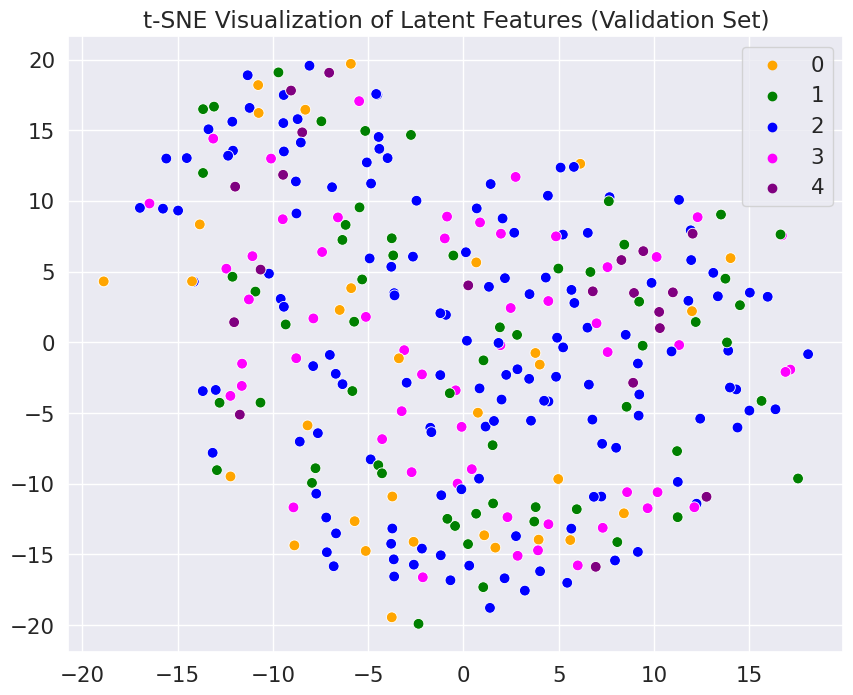

In [17]:
latent_features = extract_latent_features(model, X_validation, output_layer='dense_1')
plot_ls_tsne(latent_features, np.argmax(y_validation, axis=-1), title='t-SNE Visualization of Latent Features (Validation Set)')

97/97 ━━━━━━━━━━━━━━━━━━━━ 27s 278ms/step


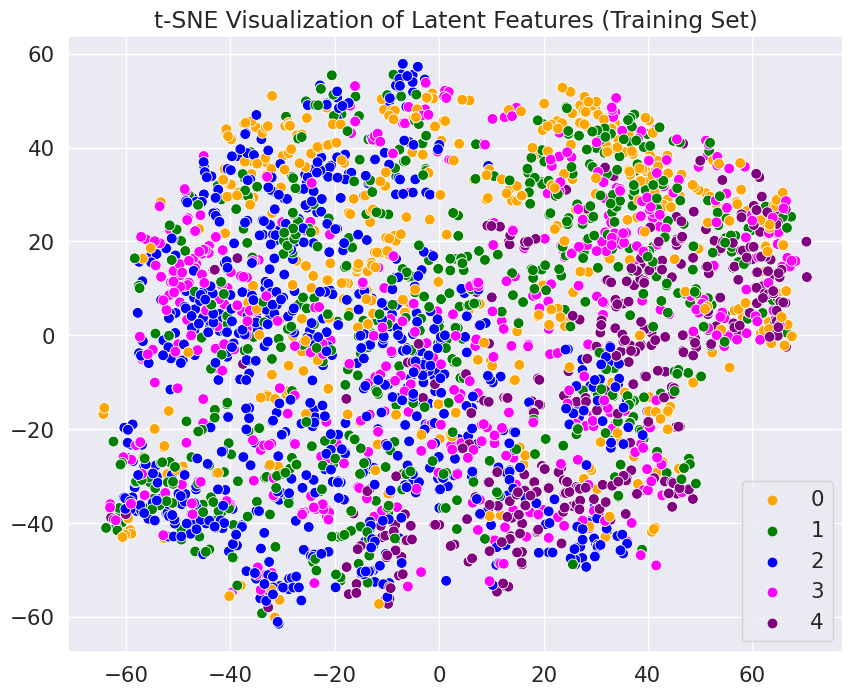

In [19]:
latent_features = extract_latent_features(model, X_train, output_layer='dense_1')
plot_ls_tsne(latent_features, np.argmax(y_train, axis=-1), title='t-SNE Visualization of Latent Features (Training Set)')

## SimCLR for Contrastive Learning
Source paper: https://arxiv.org/abs/2002.05709

#### Contrastive loss
$$\mathcal{l}_{i,j} = -\log{\frac{\exp{(\text{sim}(z_i, z_j) / \tau)}}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]} \exp{(\text{sim}(z_i, z_k) / \tau)}}}$$

In [10]:
tf.keras.backend.clear_session()

from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K

# Set hyperparameters
input_shape = (224, 224, 3)
projection_dim = 128  # Dimension of the projection head
batch_size = 64
temperature = 0.1

# Step 1: Data Augmentation Pipeline
class Augment(tf.keras.layers.Layer):
    def __init__(self):
        super(Augment, self).__init__()
        self.augment = tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.2),
            layers.RandomZoom(0.2),
            layers.RandomContrast(0.2),
        ])

    def call(self, x):
        return self.augment(x)

# Step 2: Define the Encoder Backbone
base_model = tf.keras.applications.MobileNetV2(
    include_top=False, input_shape=input_shape, pooling="avg"
)
for layer in base_model.layers[:-20]:  # Keep the last 20 layers trainable
    layer.trainable = False

# Step 3: Add Projection Head
class ProjectionHead(Model):
    def __init__(self, projection_dim):
        super(ProjectionHead, self).__init__()
        self.dense1 = layers.Dense(512, activation="relu")
        self.dense2 = layers.Dense(projection_dim, activation=None)

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return tf.math.l2_normalize(x, axis=1)  # L2 normalization

# Full SimCLR Model
class SimCLR(Model):
    def __init__(self, encoder, projection_dim):
        super(SimCLR, self).__init__()
        self.encoder = encoder
        self.projection_head = ProjectionHead(projection_dim)
        self.augment = Augment()

    def call(self, x):
        augmented_1 = self.augment(x)
        augmented_2 = self.augment(x)

        encoded_1 = self.encoder(augmented_1)
        encoded_2 = self.encoder(augmented_2)

        projection_1 = self.projection_head(encoded_1)
        projection_2 = self.projection_head(encoded_2)

        return projection_1, projection_2

# Step 4: Contrastive Loss
def contrastive_loss(projections_1, projections_2, temperature):
    batch_size = tf.shape(projections_1)[0]

    # Normalize the projections
    projections_1 = tf.math.l2_normalize(projections_1, axis=1)
    projections_2 = tf.math.l2_normalize(projections_2, axis=1)

    # Concatenate projections
    projections = tf.concat([projections_1, projections_2], axis=0)

    # Compute similarity matrix
    similarity_matrix = tf.matmul(projections, projections, transpose_b=True)

    # Create labels
    labels = tf.range(batch_size)
    labels = tf.concat([labels, labels], axis=0)

    # Apply temperature scaling
    similarity_matrix /= temperature

    # Compute loss
    loss = tf.keras.losses.sparse_categorical_crossentropy(
        labels, similarity_matrix, from_logits=True
    )
    return tf.reduce_mean(loss)

# Step 5: Training Step
@tf.function
def train_step(model, images, optimizer):
    with tf.GradientTape() as tape:
        projections_1, projections_2 = model(images)
        loss = contrastive_loss(projections_1, projections_2, temperature)

    gradients = tape.gradient(loss, model.trainable_variables)
    gradients = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gradients]  # Clip gradients
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Step 6: Training Loop
def train_simclr(dataset, epochs):
    model = SimCLR(base_model, projection_dim)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    for epoch in range(epochs):
        for step, images in enumerate(dataset):
            loss = train_step(model, images, optimizer)

            if step % 100 == 0:
                print(f"Epoch {epoch+1}, Step {step}, Loss: {loss:.4f}")

    return model

# Step 7: Prepare Dataset 
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    return image

def create_tf_dataset(X, y):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.map(lambda x, y: (preprocess(x, y))).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Example: Using X_train and y_train
# Assuming X_train is an array of images and y_train is an array of one-hot labels
train_dataset = create_tf_dataset(X_train, y_train)

# Train the model
simclr_model = train_simclr(train_dataset, epochs=10)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1, Step 0, Loss: 2.6948
Epoch 2, Step 0, Loss: 1.2651
Epoch 3, Step 0, Loss: 1.1974
Epoch 4, Step 0, Loss: 1.1578
Epoch 5, Step 0, Loss: 1.1840
Epoch 6, Step 0, Loss: 1.1099
Epoch 7, Step 0, Loss: 1.0873
Epoch 8, Step 0, Loss: 1.0932
Epoch 9, Step 0, Loss: 1.0492
Epoch 10, Step 0, Loss: 1.1074


In [20]:
# Step 8: Extract Latent Representations
def extract_latent_representations(model, test_dataset):
    encoder = model.encoder
    latent_representations = []

    for images in test_dataset:  # Assuming test_dataset contains (images, labels)
        latent = encoder(images)
        latent_representations.append(latent)

    return tf.concat(latent_representations, axis=0)

# Example usage with a test set
def preprocess_test(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    return image

def create_test_tf_dataset(X, y):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.map(lambda x, y: (preprocess_test(x, y))).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

test_dataset = create_test_tf_dataset(X_train, y_train)
latent_representations = extract_latent_representations(simclr_model, test_dataset)
print("Latent representations shape:", latent_representations.shape)

Latent representations shape: (3089, 1280)


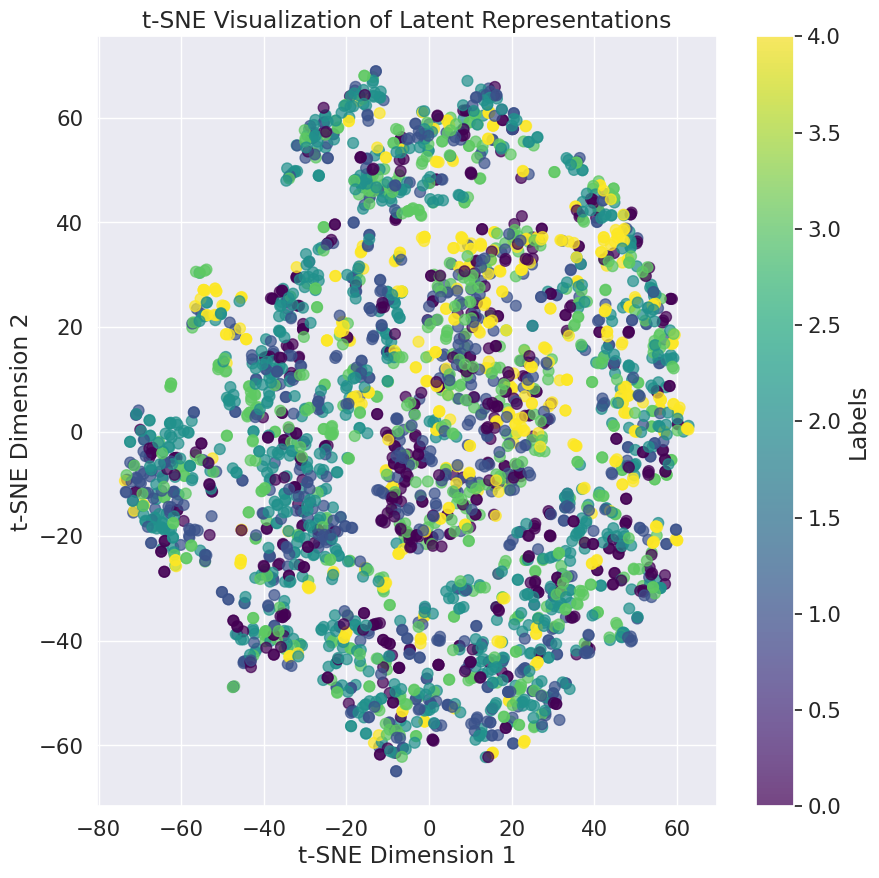

In [21]:
# Step 9: Visualize Latent Representations with t-SNE
def plot_tsne(latent_representations, labels):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_results = tsne.fit_transform(latent_representations)

    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap="viridis", s=60, alpha=0.7)
    plt.colorbar(scatter, label="Labels")
    plt.title("t-SNE Visualization of Latent Representations")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

labels_dataset = tf.data.Dataset.from_tensor_slices(np.argmax(y_train, axis=-1))
labels_dataset = labels_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
# Example: Plot latent representations
test_labels = [label.numpy() for label in labels_dataset]  # Assuming labels exist in test_dataset
plot_tsne(latent_representations.numpy(), tf.concat(test_labels, axis=0))